# Modeling

In [0]:
y_train = googl_four_df['avg']

## Simple Linear Regression Model 

In [0]:
# Convert dates to a decimal year
date = googl_four_df.index
t = date.year + (30 * (date.month - 1) + date.day) / 365
# t = date.year + (date.month / 12)
t

Float64Index([2013.0054794520547, 2013.0082191780823, 2013.0109589041097,
              2013.0191780821917,  2013.021917808219, 2013.0246575342467,
               2013.027397260274, 2013.0301369863014, 2013.0383561643835,
               2013.041095890411,
              ...
              2016.9479452054795, 2016.9561643835616,  2016.958904109589,
              2016.9616438356165,  2016.964383561644, 2016.9671232876713,
               2016.978082191781, 2016.9808219178083, 2016.9835616438356,
               2016.986301369863],
             dtype='float64', name='Date', length=1008)

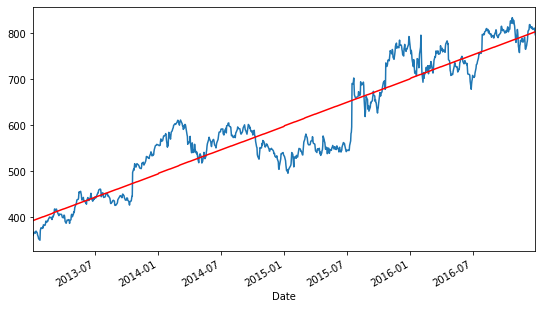

In [0]:
from sklearn.linear_model import LinearRegression

# Fit linear regression of y on t
model = LinearRegression()
model.fit(X=t.to_frame(), y=y_train)

# Predicting using the model 
y_train_ = pd.Series(
    model.predict(X=t.to_frame()),
    index=y_train.index)

# Graphing the fit 

y_train.plot.line()
y_train_.plot.line(c='red')

In [0]:
model.predict(X=t.to_frame())

array([392.91166429, 393.19376492, 393.47586556, ..., 802.23968551,
       802.52178614, 802.80388678])

## Polynomial Regression Model with Seasonality 

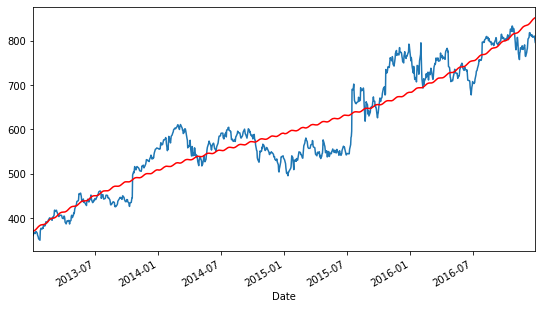

In [0]:
import numpy as np
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures
from sklearn.pipeline import make_union, make_pipeline

# Fit linear regression on t, t^2, sin(2 pi t), cos(2 pi t)
pipeline = make_pipeline(
    make_union(
        PolynomialFeatures(degree=3, include_bias=False),
        FunctionTransformer(lambda t: np.sin(2 * 12 * np.pi * t)),
        FunctionTransformer(lambda t: np.cos(2 * 12 * np.pi * t))
    ),
    LinearRegression()
)
pipeline.fit(X=t.to_frame(), y=y_train)

# Store model predictions in a Series for easy plotting
y_train_ = pd.Series(
    pipeline.predict(t.to_frame()),
    index=y_train.index
)

# Plot the data and the fitted trend
y_train.plot.line()
y_train_.plot.line(c='red')

In [0]:
googl_four_df['t'] = t
googl_four_df.head()

,Open,High,Low,Close,Volume,OpenInt,avg,Year,Month,Weekday Name,Month Name,t
Date,,,,,,,,,,,,
2013-01-02,359.71,363.50,358.28,361.62,5083536,0,360.890,2013,1,Wednesday,Jan,2013.005479
2013-01-03,362.32,365.96,360.36,361.84,4636280,0,363.160,2013,1,Thursday,Jan,2013.008219
2013-01-04,364.67,370.74,363.84,368.98,5527104,0,367.290,2013,1,Friday,Jan,2013.010959
2013-01-07,367.72,369.69,365.29,367.38,3311534,0,367.490,2013,1,Monday,Jan,2013.019178
2013-01-08,367.77,368.15,362.22,366.65,3352074,0,365.185,2013,1,Tuesday,Jan,2013.021918


## Generalized Least Squares Model

Since a normal regression model does not account for the fact that errors/residuals are correlated over time, and generalized least squares does account for this.

In [0]:
exo = googl_four_df[['t', 'Weekday Name', 'Month Name']]
exo = pd.get_dummies(exo)
exo.tail()

,t,Weekday Name_Friday,Weekday Name_Monday,Weekday Name_Thursday,Weekday Name_Tuesday,Weekday Name_Wednesday,Month Name_Apr,Month Name_Aug,Month Name_Dec,Month Name_Feb,Month Name_Jan,Month Name_Jul,Month Name_Jun,Month Name_Mar,Month Name_May,Month Name_Nov,Month Name_Oct,Month Name_Sep
Date,,,,,,,,,,,,,,,,,,
2016-12-23,2016.967123,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2016-12-27,2016.978082,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2016-12-28,2016.980822,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
2016-12-29,2016.983562,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2016-12-30,2016.986301,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


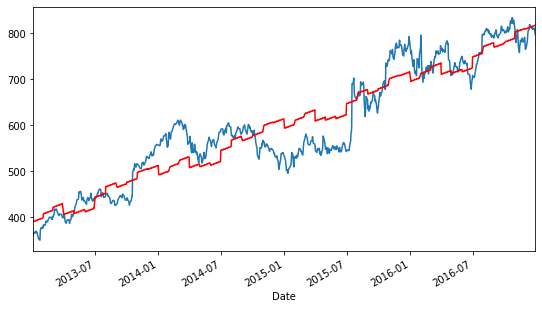

In [0]:
import statsmodels.api as sm

# price_list = prices.tolist()

first_gls = sm.GLS(endog = y_train, exog = exo)
gls1_results = first_gls.fit()
gls1_pred = gls1_results.predict(exo)

# Store model predictions in a Series for easy plotting
y_train_ = pd.Series(
    gls1_pred
)

# Plot the data and the fitted trend
y_train.plot.line()
y_train_.plot.line(c='red')


In [0]:
gls1_pred

Date
2013-01-02    390.343040
2013-01-03    391.554171
2013-01-04    391.268905
2013-01-07    391.199027
2013-01-08    392.317648
                 ...    
2016-12-23    814.885233
2016-12-27    815.933976
2016-12-28    815.905558
2016-12-29    817.116690
2016-12-30    816.831424
Length: 1008, dtype: float64

## ARIMA Models

First, to determine the validity of fitting an ARIMA model to these data, we had to test for stationarity. Test details found through this link: https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/

In [0]:
#define function for ADF test
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    dfoutput = round(dfoutput, 2)
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = round(value , 2)
    print (dfoutput)

#apply adf test on the series
adf_test(y_train)

Results of Dickey-Fuller Test:
Test Statistic                   -1.25
p-value                           0.65
#Lags Used                        4.00
Number of Observations Used    1003.00
Critical Value (1%)              -3.44
Critical Value (5%)              -2.86
Critical Value (10%)             -2.57
dtype: float64


The ADF test shows that there is not stationarity in the time series, which means differencing is needed for modeling this time series. 

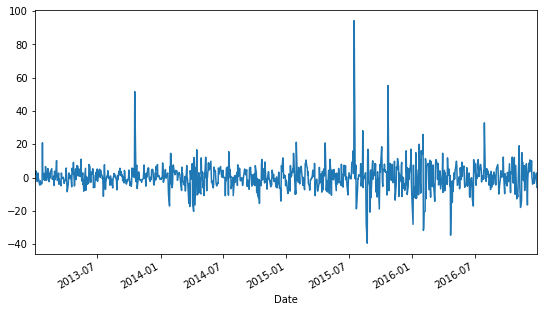

In [0]:
diff1 = y_train.diff()

# 1st Differencing
(diff1).plot.line()
# plot_acf(y_train.diff().dropna())

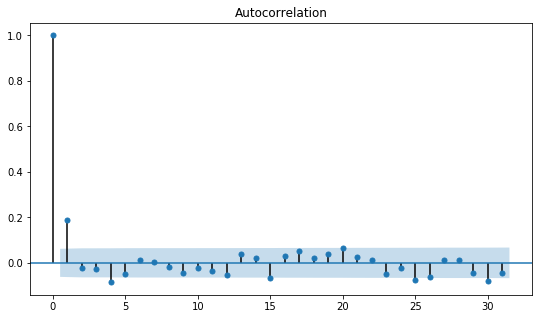

In [0]:
diff1_acf = plot_acf(diff1.dropna())

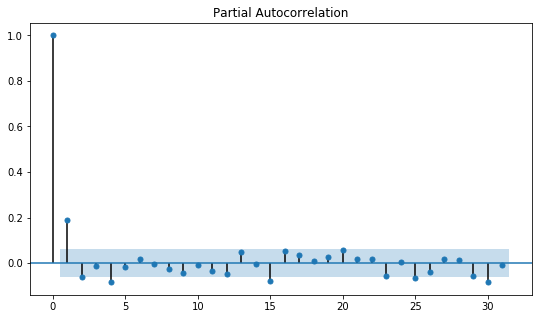

In [0]:
diff1_pacf = plot_pacf(diff1.dropna())

In [0]:
adf_test(diff1.dropna())

Results of Dickey-Fuller Test:
Test Statistic                  -16.91
p-value                           0.00
#Lags Used                        3.00
Number of Observations Used    1003.00
Critical Value (1%)              -3.44
Critical Value (5%)              -2.86
Critical Value (10%)             -2.57
dtype: float64


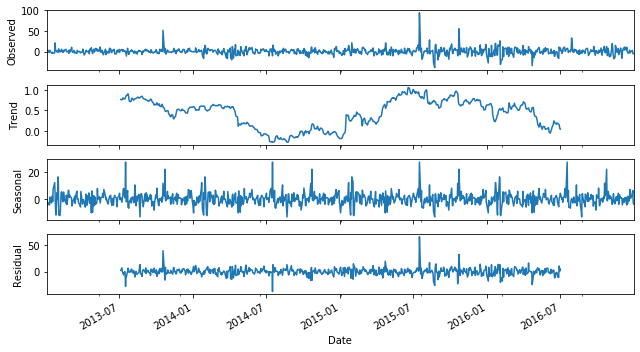

In [0]:
decomp = sm.tsa.seasonal_decompose(diff1.dropna(), model = 'additive',freq=252)
f = decomp.plot()
matplotlib.rcParams['figure.figsize'] = [9.0, 5.0]

First differencing solves the stationarity. 

In [0]:
from statsmodels.tsa.arima_model import ARIMA

model111 = ARIMA(y_train[:-252], order=(1,1,1))#, freq = 'D')
model111_fit = model111.fit(trend='nc')
print(model111_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                  D.avg   No. Observations:                  755
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2579.419
Method:                       css-mle   S.D. of innovations              7.371
Date:                Sun, 15 Mar 2020   AIC                           5164.838
Time:                        20:12:14   BIC                           5178.718
Sample:                             1   HQIC                          5170.185
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
ar.L1.D.avg    -0.0844      0.192     -0.440      0.660      -0.460       0.291
ma.L1.D.avg     0.2667      0.185      1.440      0.150      -0.096       0.630
                                    Roots       

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [0]:
gls1_results.aic

10534.188788002451

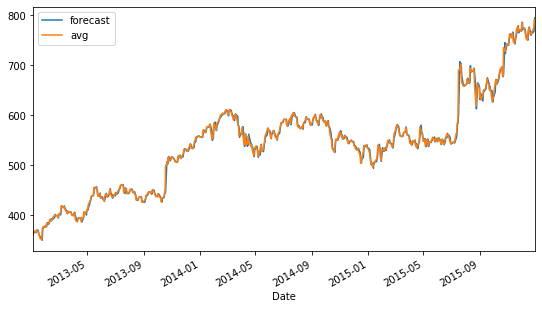

In [0]:
pl = model111_fit.plot_predict(dynamic=False)
plt.show()

In [0]:
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

In [0]:
f = model111_fit.predict()
fits_arima = []
for i in range(len(f)):
  fi = inverse_difference(y_train[:-252], f[i], -i)
  fits_arima.append(fi)

fits_arima[0:5]

[360.89,
 363.55422790004195,
 367.93549139676554,
 367.35431344011886,
 364.80097762098615]

In [0]:
from sklearn.metrics import mean_squared_error

mean_squared_error(fits_arima, y_train[:-253]) ** .5

1.3474925198864283

In [0]:
forc = model111_fit.predict(start= 755, end = 1006)
edited_forecasts_2016 = []
for i in range(len(forc)):
  fi_p = inverse_difference(y_train[-252:], forc[i + 754], -i)
  edited_forecasts_2016.append(fi_p)

edited_forecasts_2016[0:5]

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


[754.0231097109523,
 761.0096578427907,
 756.9844765498486,
 745.2849143497626,
 739.5208513833119]

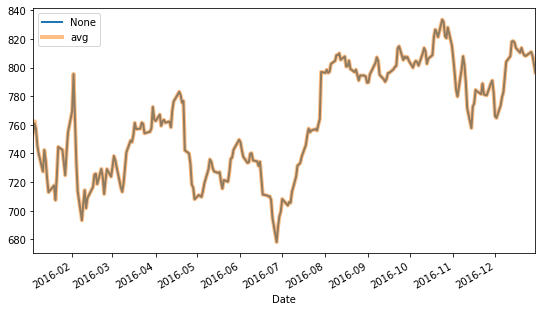

In [0]:
forecast_2016 = pd.Series(edited_forecasts_2016, index=y_train[-252:].index)
forecast_2016.plot.line(legend=True, lw=2)
y_train[-252:].plot.line(legend=True, lw = 4, alpha = .5)

In [0]:
from sklearn.metrics import mean_squared_error

mean_squared_error(forecast_2016, y_train[-252:]) ** .5

0.10417464121889002

In [0]:
import itertools

In [0]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [0]:
y_train.index = pd.DatetimeIndex(y_train.index).to_period('D')


In [0]:
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [0]:
all_sarima = pd.Series()

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y_train, order=param, seasonal_order=param_seasonal, 
                                            enforce_stationarity=False, enforce_invertibility=False)
            results = mod.fit()
            all_sarima['ARIMA{}x{}12'.format(param, param_seasonal)] = results.aic
            #print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            continue

all_sarima.idxmin()

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


'ARIMA(0, 1, 1)x(0, 1, 1, 12)12'

In [0]:
all_sarima.min()

6834.049689293803

In [0]:
mod = sm.tsa.statespace.SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), 
                                            enforce_stationarity=False, enforce_invertibility=False)

## Long Short Term Memory Machine Learning Implementation

This modeling technique is a form of a Recurrent Neural Network that accounts for both recent history data points and long term history data points to make predictions. It predicts the value for time (t + 1) in time t, meaning that the prediction at time 0 is the prediciton for the value in the next period, in this implementation. 

Sources: 

https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/


In [0]:
import tensorflow as tf

### Model focused on minimizing Train Error, predictions not as good

Using TensorFlow backend.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where








Test RMSE: 3.520


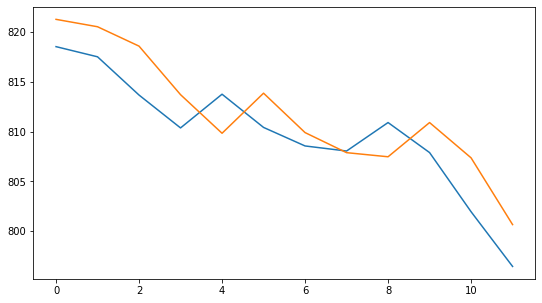

In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy as np

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = pd.DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = pd.concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = np.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)#, validation_split = .33)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

# transform data to be stationary
raw_values = y_train.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 10, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	# print('12/%d/16, Predicted=%f, Expected=%f' % (i+1 + 12, yhat, expected))

# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:]) # orange line 
pyplot.plot(predictions)
# pyplot.plot.legend()
pyplot.show()


In [0]:
len(raw_values[-12:])

12

In [0]:
lstm_fitted = lstm_model.predict(train_reshaped, batch_size=1)
fitted_vals = []

for i in range(len(train_scaled)):
  X, y = train_scaled[i, 0:-1], lstm_fitted[i]
  yhat = invert_scale(scaler, X, y)
  yhat = inverse_difference(raw_values, yhat, -i)
  # print(len(train_scaled)+1-i)
  fitted_vals.append(yhat)

fitted_vals[0:5]

[359.99690020710227,
 362.85657086595893,
 367.6591386455297,
 367.6940609562397,
 364.90952038019896]

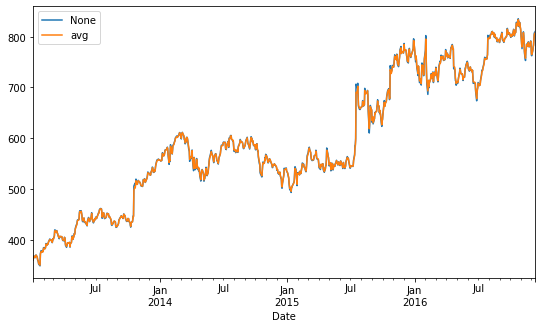

In [0]:
fitted_vals = pd.Series(fitted_vals, index = y_train.index[:-13])
fitted_vals.plot.line(legend=True)
y_train[:-13].plot.line(legend=True)

In [0]:
train_rmse = sqrt(mean_squared_error(raw_values[:-13], fitted_vals))
print('Train RMSE: %.3f' % train_rmse)

Train RMSE: 1.659


### Model focused on minizing Test Error, compromising fit of the training data

Test RMSE: 8.699


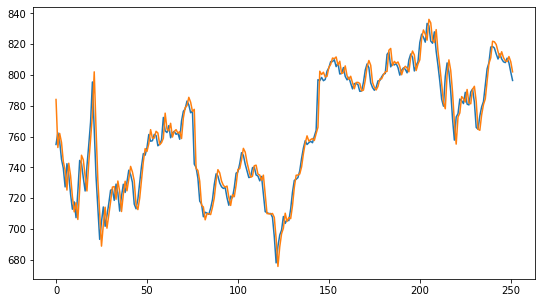

In [0]:
# split data into train and test-sets
train1, test1 = supervised_values[0:-252], supervised_values[-252:]

# transform the scale of the data
scaler, train_scaled1, test_scaled1 = scale(train1, test1)

# fit the model
lstm_model1 = fit_lstm(train_scaled1, 1, 10, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped1 = train_scaled1[:, 0].reshape(len(train_scaled1), 1, 1)
lstm_model1.predict(train_reshaped1, batch_size=1)

# walk-forward validation on the test data
predictions1 = list()
for i in range(len(test_scaled1)):
	# make one-step forecast
	X1, y1 = test_scaled1[i, 0:-1], test_scaled1[i, -1]
	yhat1 = forecast_lstm(lstm_model1, 1, X1)
	# invert scaling
	yhat1 = invert_scale(scaler, X1, yhat1)
	# invert differencing
	yhat1 = inverse_difference(raw_values, yhat1, len(test_scaled1)+1-i)
	# store forecast
	predictions1.append(yhat1)
	expected1 = raw_values[len(train1) + i + 1]
	# print('12/%d/16, Predicted=%f, Expected=%f' % (i+1 + 12, yhat, expected))

# report performance
rmse1 = sqrt(mean_squared_error(raw_values[-252:], predictions1))
print('Test RMSE: %.3f' % rmse1)
# line plot of observed vs predicted
pyplot.plot(raw_values[-252:]) # orange line 
pyplot.plot(predictions1)
# pyplot.plot.legend()
pyplot.show()

In [0]:
lstm_fitted1 = lstm_model1.predict(train_reshaped1, batch_size=1)
fitted_vals1 = []

for i in range(len(train_scaled1)):
  X1, y1 = train_scaled1[i, 0:-1], lstm_fitted1[i]
  yhat1 = invert_scale(scaler, X1, y1)
  yhat1 = inverse_difference(raw_values, yhat1, -i)
  fitted_vals1.append(yhat1)

fitted_vals1[0:5]

[361.2252138826251,
 363.9191141851246,
 368.5628263364732,
 368.69568540111186,
 366.06335244178774]

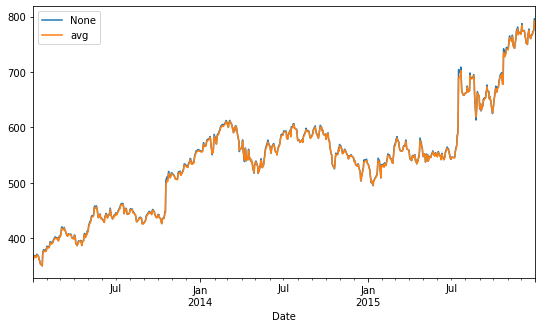

In [0]:
fitted_vals1 = pd.Series(fitted_vals1, index = y_train.index[:-253])
fitted_vals1.plot.line(legend=True)
y_train[:-252].plot.line(legend=True)

In [0]:
train_rmse1 = sqrt(mean_squared_error(raw_values[:-253], fitted_vals1))
print('Train RMSE: %.3f' % train_rmse1)


Train RMSE: 1.733


## Model Evaluation

In [0]:
def generate_t(dates):
  return dates.year + (30 * (dates.month - 1) + dates.day) / 365

In [0]:
from sklearn.model_selection import TimeSeriesSplit

def evaluate_model(model_name, y, gls_exogenous = exo):

  errors = []
  splits = TimeSeriesSplit(n_splits = 5)
  
  for train_index, test_index in splits.split(y):
    train_data = y[train_index]
    test_data = y[test_index]

    if model_name == 'linear' or model_name == 'polynomial' or model_name == 'GLS': 
      train_dates = googl_four_df.iloc[train_index]['avg'].index
      test_dates = googl_four_df.iloc[test_index]['avg'].index
      t_train = generate_t(train_dates)
      t_test = generate_t(test_dates)

      # testing and training linear model 
      if model_name == 'linear':
        model = LinearRegression()
        model.fit(X = t_train.to_frame(), y = train_data)
        fitted_vals = model.predict(t_train.to_frame())
        pred_vals = model.predict(t_test.to_frame())

      # testing and training polynomial model (3rd degree, 12 periods)
      elif model_name == 'polynomial':
        pipeline = make_pipeline(
            make_union(
                PolynomialFeatures(degree=3, include_bias=False),
                FunctionTransformer(lambda t: np.sin(2 * 12 * np.pi * t)),
                FunctionTransformer(lambda t: np.cos(2 * 12 * np.pi * t))
            ),
            LinearRegression()
        )
        pipeline.fit(X=t_train.to_frame(), y=train_data)
        fitted_vals = pipeline.predict(t_train.to_frame())
        pred_vals = pipeline.predict(t_test.to_frame())   

      # GLS evaluation
      elif model_name == 'GLS':
        e_train = gls_exogenous.loc[train_dates]
        e_test = gls_exogenous.loc[test_dates]
        e_train.index = train_data.index
        # print(train_data.index, '\n', e_train.index)
        gls = sm.GLS(endog = train_data, exog = e_train)
        gls_fit = gls.fit()
        fitted_vals = gls_fit.predict(e_train)
        pred_vals = gls_fit.predict(e_test)

    elif model_name == 'ARIMA':
      model_arima = ARIMA(train_data, order=(1,1,1))#, freq = 'D')
      model_arima_fit = model_arima.fit(trend='nc')

      # extract fitted values from arima 
      f = model_arima_fit.predict()
      fitted_vals = []
      for i in range(len(f)):
        fi = inverse_difference(train_data, f[i], -i)
        fitted_vals.append(fi)
      
      # extract prediction for test data 
      test_start = len(train_data)
      test_end = test_start + len(test_data) - 1
      forc = model_arima_fit.predict(start= test_start, end = test_end)
      pred_vals = []
      for i in range(len(forc)):
        fi_p = inverse_difference(test_data, forc[i], -i)
        pred_vals.append(fi_p)

      fitted_vals = np.asarray(fitted_vals)
      train_data = train_data[:-1]

    # SARIMA evaluation
    elif model_name == 'SARIMA':
      mod = sm.tsa.statespace.SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), 
                                            enforce_stationarity=False, enforce_invertibility=False)
      mod_fit = mod.fit()
      fitted_vals = mod_fit.get_prediction().predicted_mean
      pred_vals = mod_fit.get_forecast(steps = len(test_data)).predicted_mean

    # LSTM evaluation
    elif model_name == 'LSTM':
      
      raw_values = train_data.append(test_data).values 

      raw_train_values = train_data.values
      diff_train_values = difference(raw_train_values, 1)

      raw_test_values = test_data.values
      diff_test_values = difference(raw_test_values, 1)

      supervised_train = timeseries_to_supervised(diff_train_values, 1)
      supervised_test = timeseries_to_supervised(diff_test_values, 1)

      supervised_train_val = supervised_train.values
      supervised_test_val = supervised_test.values

      scaler, train_scaled, test_scaled = scale(supervised_train_val, supervised_test_val)

      lstm_model = fit_lstm(train_scaled, 1, 10, 4)
      train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
      lstm_model.predict(train_reshaped, batch_size=1)

      fitted_vals = []
      for i in range(len(train_scaled)):
        X, y1 = train_scaled[i, 0:-1], lstm_fitted[i]
        yhat = invert_scale(scaler, X, y1)
        yhat = inverse_difference(raw_values, yhat, -i)
        fitted_vals.append(yhat)

      pred_vals = []
      for i in range(len(test_scaled)):
        X, y2 = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        yhat = invert_scale(scaler, X, yhat)
        yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        pred_vals.append(yhat)

      train_data = train_data[:-1]
      test_data = test_data[:-1]
        
    else:
      raise ValueError('Enter one of the following valid models: linear, polynomial, GLS, ARIMA, SARIMA, LSTM')

    train_error = mean_squared_error(fitted_vals, train_data) ** .5 
    test_error = mean_squared_error(pred_vals, test_data) ** .5 
    errors.append([train_error, test_error])

  return pd.DataFrame(data= errors, columns=['train error', 'test error'])


In [0]:
linear_evaluation = evaluate_model('linear', y_train)
polynomial_evaluation = evaluate_model('polynomial', y_train)
gls_evaluation = evaluate_model('GLS', y_train)
arima_evaluation = evaluate_model('ARIMA', y_train)
sarima_evaluation = evaluate_model('SARIMA', y_train)
lstm_evaluation = evaluate_model('LSTM', y_train)

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [0]:
all_evals = {'linear' : linear_evaluation, 
             'polynomial':polynomial_evaluation, 
             'GLS':gls_evaluation, 
             'ARIMA':arima_evaluation,
             'SARIMA':sarima_evaluation, 
             'LSTM':lstm_evaluation}
test_errors = pd.Series()
train_errors = pd.Series() 

for k in all_evals: 
  cur = all_evals[k]
  test_errors[k] = cur['test error'].mean()
  train_errors[k] = cur['train error'].mean()

all_errors = pd.concat([test_errors, train_errors], axis=1)
all_errors.columns = ['avg test error', 'avg train error']
all_errors.sort_values(by='avg test error')

,avg test error,avg train error
ARIMA,0.079866,1.141291
LSTM,1.355678,1.454937
SARIMA,65.066475,22.948108
linear,70.307618,34.491820
polynomial,156.077550,27.017984
GLS,5957.358042,29.342050


# Sentiment Analysis

## Afinn Lexicon


In [0]:
!pip install afinn

In [0]:
from afinn import Afinn
from nltk.corpus import gutenberg
import textwrap
afinn = Afinn()

In [0]:
sent = []
for i in range(0,len(articles_df["headline.main"])):
  x = afinn.score(articles_df["headline.main"][i])
  sent.append(x)

sentiments = pd.DataFrame()
sentiments["sentiments"] = pd.Series(sent)

In [0]:
article_sentiments = sentiments.join(articles_df)

In [0]:
for i in range(0,len(article_sentiments["pub_date"])):
  article_sentiments["pub_date"].iloc[i] = article_sentiments["pub_date"].iloc[i][0:10]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [0]:
article_sentiments["Year"] = [i[0:4] for i in article_sentiments["pub_date"]]
article_sentiments["Month"] = [i[5:7] for i in article_sentiments["pub_date"]]


In [0]:
yearly_sentiments = article_sentiments[article_sentiments["sentiments"] != 0].groupby(["Year","Month"])["sentiments"].mean()

In [0]:
yearly_sentiments = yearly_sentiments.to_frame().reset_index()

In [0]:
googl_senti = googl_four_df.reset_index()
new = googl_senti["Date"].astype(str).str.split("-",expand = True)
googl_senti["Year"] = new[0].astype(str)
googl_senti["Month"] = new[1].astype(str)
googl_senti["Day"] = new[2].astype(str)

In [0]:
googl_senti.head()

,Date,Open,High,Low,Close,Volume,OpenInt,avg,Year,Month,Weekday Name,Day
0,2013-01-02,359.71,363.50,358.28,361.62,5083536,0,360.890,2013,01,Wednesday,02
1,2013-01-03,362.32,365.96,360.36,361.84,4636280,0,363.160,2013,01,Thursday,03
2,2013-01-04,364.67,370.74,363.84,368.98,5527104,0,367.290,2013,01,Friday,04
3,2013-01-07,367.72,369.69,365.29,367.38,3311534,0,367.490,2013,01,Monday,07
4,2013-01-08,367.77,368.15,362.22,366.65,3352074,0,365.185,2013,01,Tuesday,08


In [0]:
yearly_sentiments["Year"] = yearly_sentiments["Year"].astype(str)
yearly_sentiments["Month"] = yearly_sentiments["Month"].astype(str)

In [0]:
googl_senti = pd.merge(googl_senti,yearly_sentiments, how = "left", left_on = ["Year", "Month"], right_on = ["Year", "Month"])

In [0]:
googl_senti.set_index("Date",inplace= True)

In [0]:
# Convert dates to a decimal year
date = googl_senti.index
t = date.year + (30 * (date.month - 1) + date.day) / 365
# t = date.year + (date.month / 12)
t

Float64Index([2013.0054794520547, 2013.0082191780823, 2013.0109589041097,
              2013.0191780821917,  2013.021917808219, 2013.0246575342467,
               2013.027397260274, 2013.0301369863014, 2013.0383561643835,
               2013.041095890411,
              ...
              2016.9479452054795, 2016.9561643835616,  2016.958904109589,
              2016.9616438356165,  2016.964383561644, 2016.9671232876713,
               2016.978082191781, 2016.9808219178083, 2016.9835616438356,
               2016.986301369863],
             dtype='float64', name='Date', length=1008)

In [0]:
googl_senti['t'] = t
exo = googl_senti[['t', 'Weekday Name', 'Month',"sentiments"]]
exo = pd.get_dummies(exo)
exo

,t,sentiments,Weekday Name_Friday,Weekday Name_Monday,Weekday Name_Thursday,Weekday Name_Tuesday,Weekday Name_Wednesday,Month_01,Month_02,Month_03,Month_04,Month_05,Month_06,Month_07,Month_08,Month_09,Month_10,Month_11,Month_12
Date,,,,,,,,,,,,,,,,,,,
2013-01-02,2013.005479,1.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
2013-01-03,2013.008219,1.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2013-01-04,2013.010959,1.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2013-01-07,2013.019178,1.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2013-01-08,2013.021918,1.0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23,2016.967123,0.6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2016-12-27,2016.978082,0.6,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
2016-12-28,2016.980822,0.6,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [0]:
from sklearn.model_selection import TimeSeriesSplit
errors = []
splits = TimeSeriesSplit(n_splits = 5)
y_train = googl_senti['avg']
for train_index, test_index in splits.split(y_train):
  train_data = y_train[train_index]
  test_data = y_train[test_index]

train_dates = googl_senti.iloc[train_index]['avg'].index
test_dates = googl_senti.iloc[test_index]['avg'].index
e_train = exo.iloc[1:864]
e_test = exo.iloc[864:1007]

In [0]:
yearly_sentiments["day"] = "01"
yearly_sentiments["Date"] = (yearly_sentiments["Year"] + "-" +
                             yearly_sentiments["Month"] + "-" +
                             yearly_sentiments["day"])
yearly_sentiments["Date"] = pd.to_datetime(yearly_sentiments["Date"])

In [0]:
yearly_sentiments.set_index("Date", inplace = True)

In [0]:
from statsmodels.tsa.arima_model import ARIMA
resid_inter = ARIMA(gls_fit.resid,order=(1,1,1))
print(resid_inter.fit().summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1007
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3536.242
Method:                       css-mle   S.D. of innovations              8.107
Date:                Tue, 17 Mar 2020   AIC                           7080.484
Time:                        00:51:40   BIC                           7100.143
Sample:                             1   HQIC                          7087.954
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0083      0.288      0.029      0.977      -0.556       0.573
ar.L1.D.y     -0.1165      0.232     -0.502      0.616      -0.571       0.338
ma.L1.D.y      0.2584      0.226      1.143      0.2

In [0]:
avg_price_month = googl_four_df.groupby(["Year","Month"])["avg"].mean().reset_index()
avg_price_month

,Year,Month,avg
0,2013,1,367.085000
1,2013,2,392.765000
2,2013,3,409.154000
3,2013,4,397.442727
4,2013,5,438.035000
5,2013,6,438.733500
6,2013,7,450.492273
7,2013,8,438.226364
8,2013,9,442.164250
9,2013,10,468.663261


In [0]:
avg_price_month["day"] = "01"
avg_price_month["Date"] = (avg_price_month["Year"].astype(str) + "-" +
                             avg_price_month["Month"].astype(str) + "-" +
                             avg_price_month["day"].astype(str))

In [0]:
avg_price_month.set_index("Date", inplace = True)

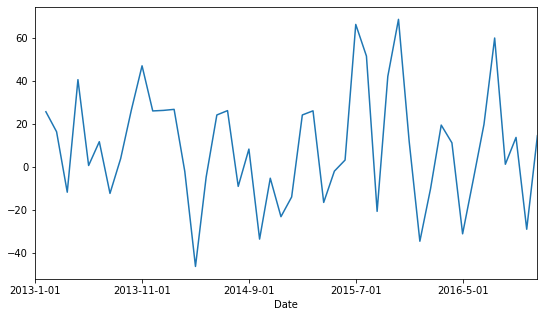

In [0]:
(avg_price_month['avg'].diff(1)).plot()

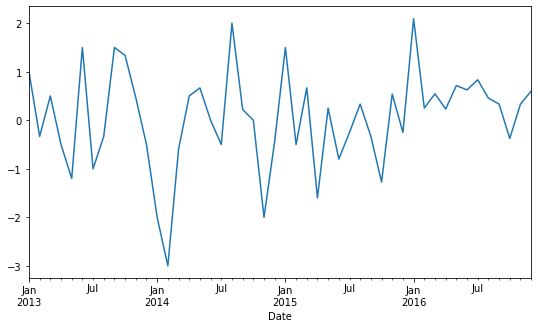

In [0]:
y_train_ = pd.Series(
    yearly_sentiments["sentiments"]
)

# Plot the data and the fitted trend
y_train_.plot.line()

Text(0, 0.5, 'Sentiment Value')

<Figure size 648x360 with 0 Axes>

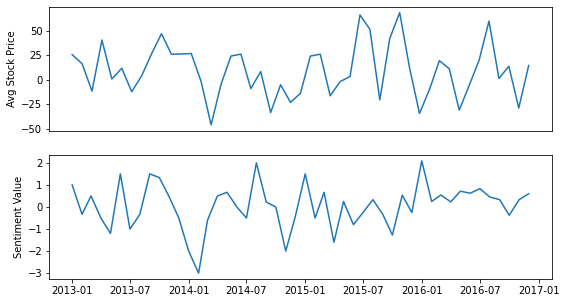

In [0]:
plt.figure()
f, axes = plt.subplots(2, 1)
axes[0].plot(avg_price_month['avg'].diff(1))
axes[0].set_ylabel('Avg Stock Price')
axes[0].tick_params(axis = 'x', bottom = False, labelbottom = False)

axes[1].plot(y_train_)
axes[1].set_ylabel('Sentiment Value')